In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2DTranspose, Input, Concatenate
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.utils import plot_model
from tensorflow_examples.models.pix2pix import pix2pix
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
from matplotlib import pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.0.0', with_info=True)

In [4]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [5]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [6]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask

In [7]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [8]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [9]:
train_dataset = (train.cache()
                 .shuffle(BUFFER_SIZE)
                 .batch(BATCH_SIZE)
                 .repeat()
                 .prefetch(buffer_size=tf.data.experimental.AUTOTUNE))
test_dataset = test.batch(BATCH_SIZE)

In [10]:
def display(display_list):
    plt.figure(figsize=(15,15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(array_to_img(display_list[i]))
        plt.axis('off')
        
    plt.show()

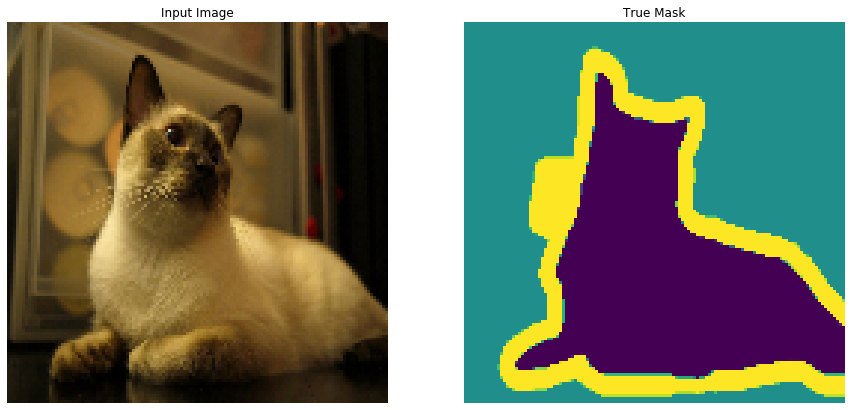

In [11]:
for image, mask in train.take(1):
    display([image, mask])
    break
sample_image, sample_mask = image, mask # Later use

In [12]:
OUTPUT_CHANNELS = 3

In [13]:
base_model = MobileNetV2(input_shape=(128,128,3), include_top=False)
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [14]:
layer_names = [
    'block_1_expand_relu',
    'block_3_expand_relu',
    'block_6_expand_relu',
    'block_13_expand_relu',
    'block_16_project',
]
layers = [base_model.get_layer(name).output for name in layer_names]

down_stack = Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),
    pix2pix.upsample(256, 3),
    pix2pix.upsample(128, 3),
    pix2pix.upsample(64, 3),
]

In [16]:
def unet_model(output_channels):
    last = Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same', activation='softmax')
    
    inputs = Input(shape=(128,128,3))
    x = inputs
    
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])
    
    x = last(x)
    
    return Model(inputs=inputs, outputs=x)

In [17]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

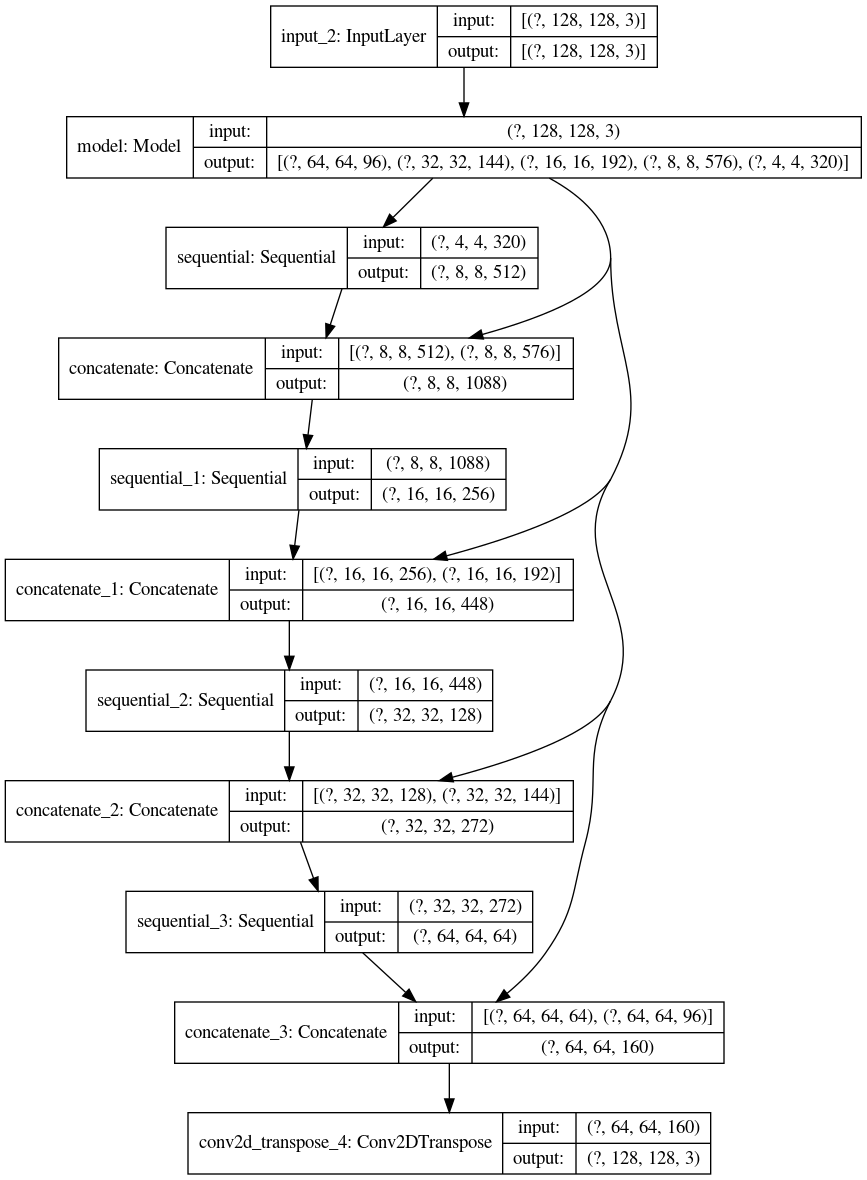

In [18]:
plot_model(model, show_shapes=True)

In [19]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [20]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

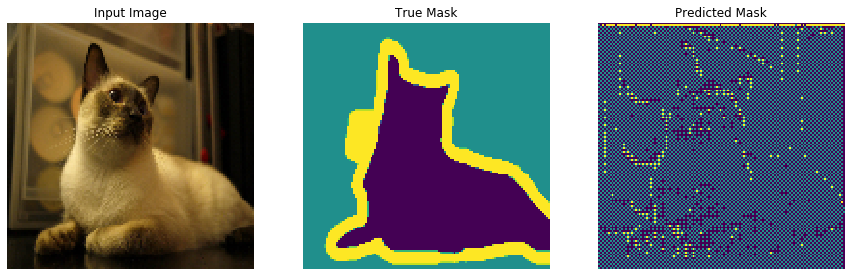

In [21]:
show_predictions()

In [22]:
class DisplayCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        #clear_output(wait=True)
        show_predictions()
        print(f'\nSample Prediction after epoch {epoch+1}\n')

Train for 115 steps, validate for 22 steps
Epoch 1/20
114/115 [============================>.] - ETA: 0s - loss: 0.4603 - accuracy: 0.8138

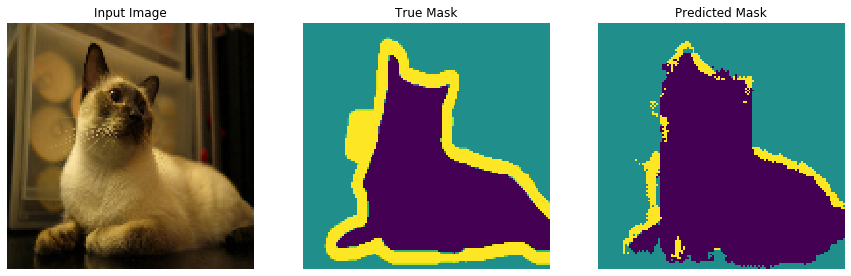


Sample Prediction after epoch 1

115/115 [==============================] - 33s 288ms/step - loss: 0.4592 - accuracy: 0.8143 - val_loss: 0.3841 - val_accuracy: 0.8539
Epoch 2/20
114/115 [============================>.] - ETA: 0s - loss: 0.2938 - accuracy: 0.8790

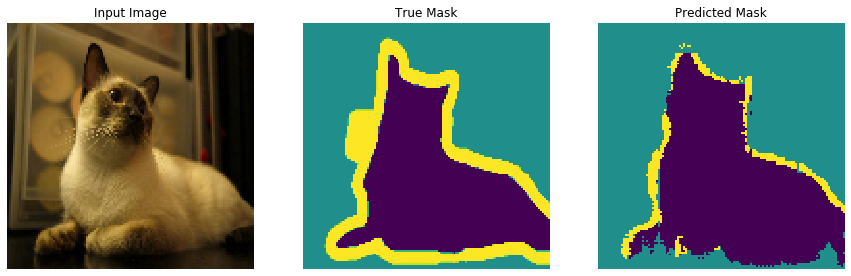


Sample Prediction after epoch 2

115/115 [==============================] - 27s 230ms/step - loss: 0.2936 - accuracy: 0.8790 - val_loss: 0.3387 - val_accuracy: 0.8619
Epoch 3/20
114/115 [============================>.] - ETA: 0s - loss: 0.2735 - accuracy: 0.8859

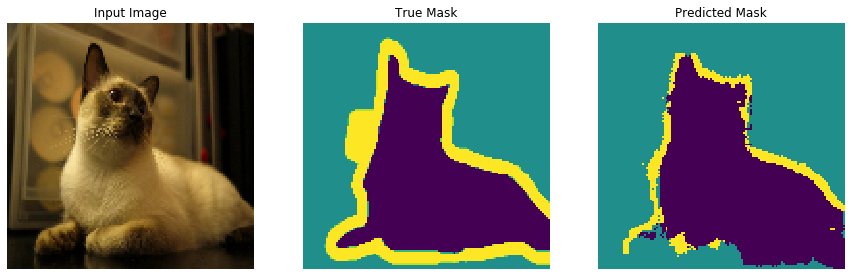


Sample Prediction after epoch 3

115/115 [==============================] - 27s 235ms/step - loss: 0.2731 - accuracy: 0.8861 - val_loss: 0.3131 - val_accuracy: 0.8727
Epoch 4/20
114/115 [============================>.] - ETA: 0s - loss: 0.2637 - accuracy: 0.8896

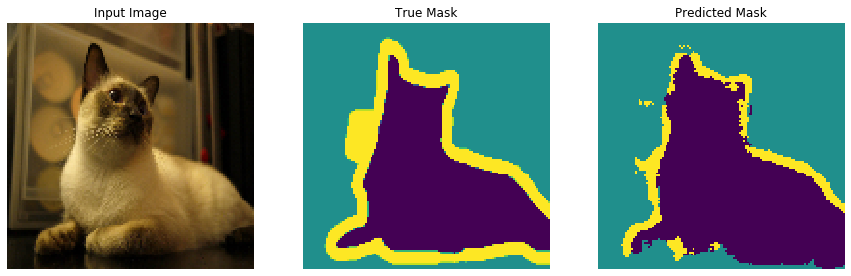


Sample Prediction after epoch 4

115/115 [==============================] - 27s 235ms/step - loss: 0.2636 - accuracy: 0.8896 - val_loss: 0.3199 - val_accuracy: 0.8715
Epoch 5/20
114/115 [============================>.] - ETA: 0s - loss: 0.2501 - accuracy: 0.8940

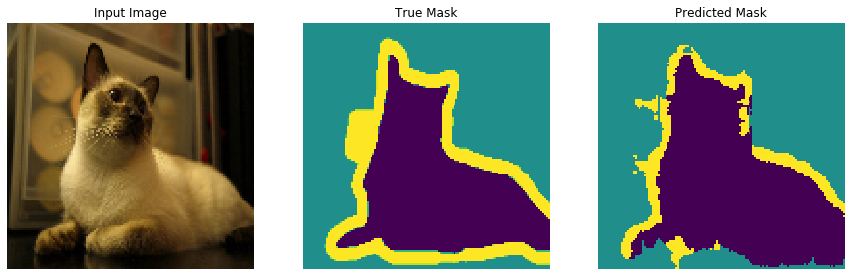


Sample Prediction after epoch 5

115/115 [==============================] - 27s 238ms/step - loss: 0.2502 - accuracy: 0.8940 - val_loss: 0.3129 - val_accuracy: 0.8752
Epoch 6/20
114/115 [============================>.] - ETA: 0s - loss: 0.2427 - accuracy: 0.8968

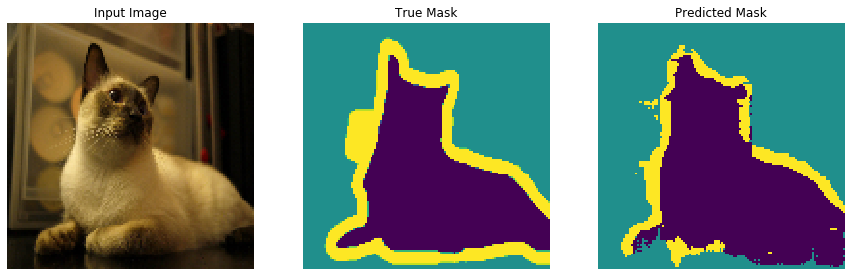


Sample Prediction after epoch 6

115/115 [==============================] - 27s 231ms/step - loss: 0.2428 - accuracy: 0.8968 - val_loss: 0.2901 - val_accuracy: 0.8836
Epoch 7/20
114/115 [============================>.] - ETA: 0s - loss: 0.2355 - accuracy: 0.8995

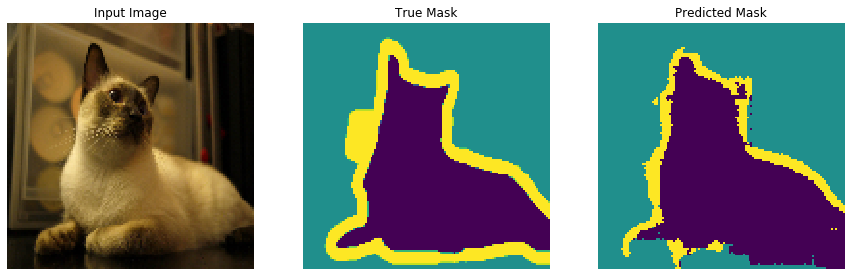


Sample Prediction after epoch 7

115/115 [==============================] - 26s 230ms/step - loss: 0.2358 - accuracy: 0.8995 - val_loss: 0.3140 - val_accuracy: 0.8748
Epoch 8/20
114/115 [============================>.] - ETA: 0s - loss: 0.2263 - accuracy: 0.9026

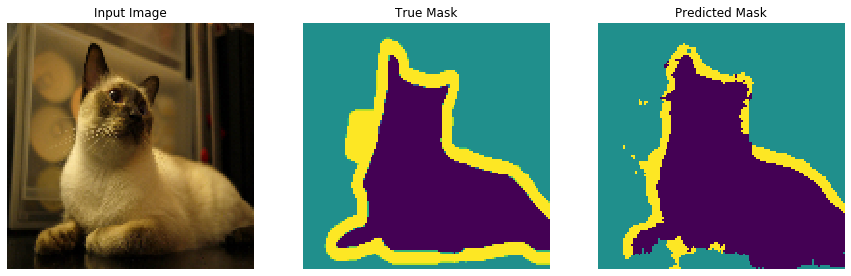


Sample Prediction after epoch 8

115/115 [==============================] - 27s 235ms/step - loss: 0.2262 - accuracy: 0.9026 - val_loss: 0.3142 - val_accuracy: 0.8763
Epoch 9/20
114/115 [============================>.] - ETA: 0s - loss: 0.2196 - accuracy: 0.9052

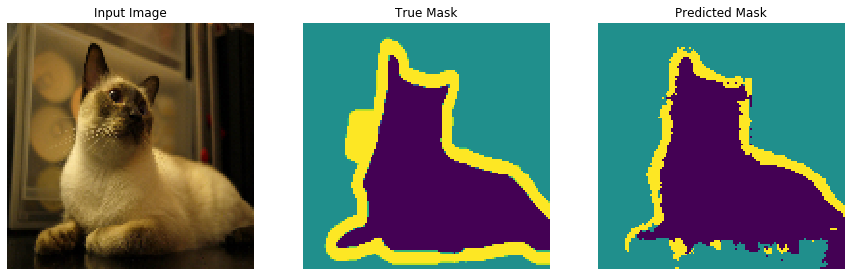


Sample Prediction after epoch 9

115/115 [==============================] - 27s 236ms/step - loss: 0.2198 - accuracy: 0.9051 - val_loss: 0.3095 - val_accuracy: 0.8787
Epoch 10/20
114/115 [============================>.] - ETA: 0s - loss: 0.2154 - accuracy: 0.9065

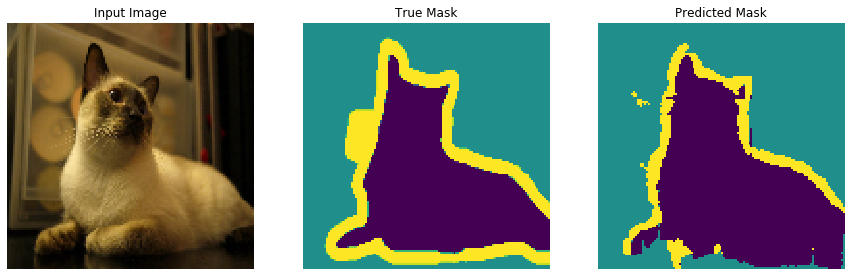


Sample Prediction after epoch 10

115/115 [==============================] - 27s 235ms/step - loss: 0.2152 - accuracy: 0.9066 - val_loss: 0.3120 - val_accuracy: 0.8766
Epoch 11/20
114/115 [============================>.] - ETA: 0s - loss: 0.2106 - accuracy: 0.9080

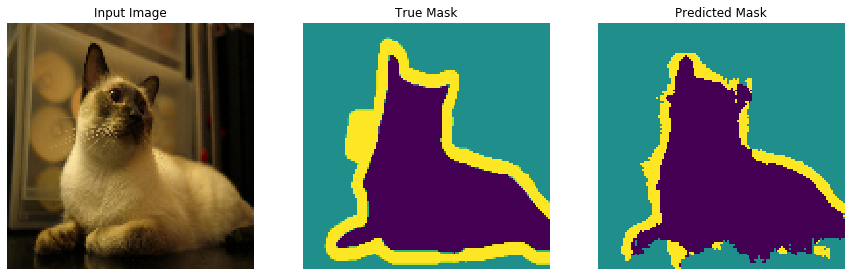


Sample Prediction after epoch 11

115/115 [==============================] - 27s 231ms/step - loss: 0.2105 - accuracy: 0.9081 - val_loss: 0.3199 - val_accuracy: 0.8795
Epoch 12/20
114/115 [============================>.] - ETA: 0s - loss: 0.2044 - accuracy: 0.9106

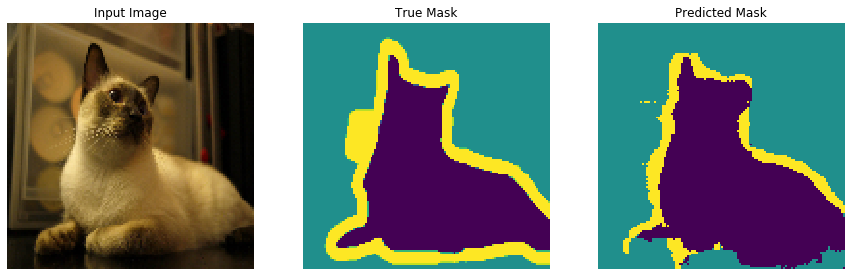


Sample Prediction after epoch 12

115/115 [==============================] - 28s 244ms/step - loss: 0.2045 - accuracy: 0.9106 - val_loss: 0.3076 - val_accuracy: 0.8829
Epoch 13/20
114/115 [============================>.] - ETA: 0s - loss: 0.1939 - accuracy: 0.9146

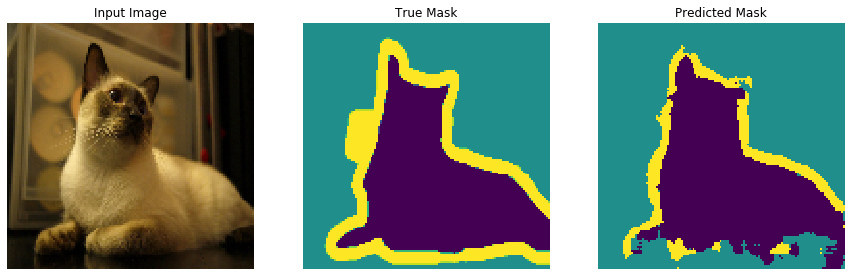


Sample Prediction after epoch 13

115/115 [==============================] - 27s 235ms/step - loss: 0.1939 - accuracy: 0.9146 - val_loss: 0.3255 - val_accuracy: 0.8774
Epoch 14/20
114/115 [============================>.] - ETA: 0s - loss: 0.1893 - accuracy: 0.9164

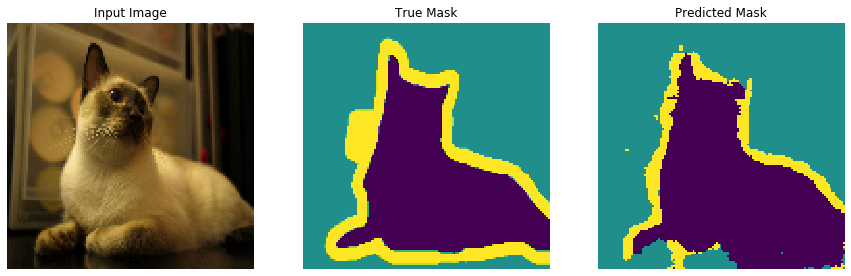


Sample Prediction after epoch 14

115/115 [==============================] - 27s 236ms/step - loss: 0.1891 - accuracy: 0.9165 - val_loss: 0.3324 - val_accuracy: 0.8785
Epoch 15/20
114/115 [============================>.] - ETA: 0s - loss: 0.1810 - accuracy: 0.9196

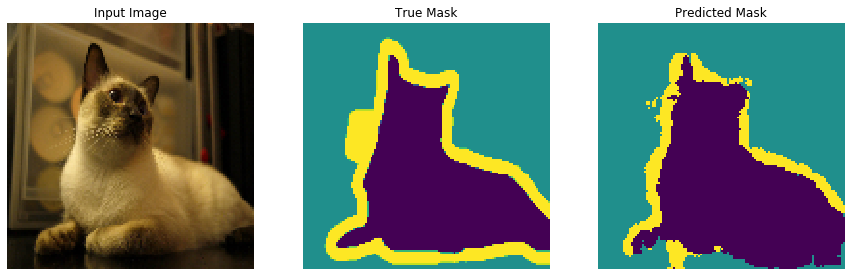


Sample Prediction after epoch 15

115/115 [==============================] - 27s 232ms/step - loss: 0.1810 - accuracy: 0.9197 - val_loss: 0.3255 - val_accuracy: 0.8802
Epoch 16/20
114/115 [============================>.] - ETA: 0s - loss: 0.1736 - accuracy: 0.9225

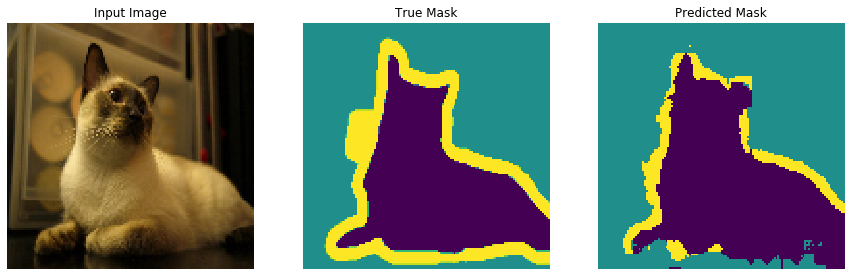


Sample Prediction after epoch 16

115/115 [==============================] - 27s 232ms/step - loss: 0.1737 - accuracy: 0.9225 - val_loss: 0.3390 - val_accuracy: 0.8782
Epoch 17/20
114/115 [============================>.] - ETA: 0s - loss: 0.1684 - accuracy: 0.9247

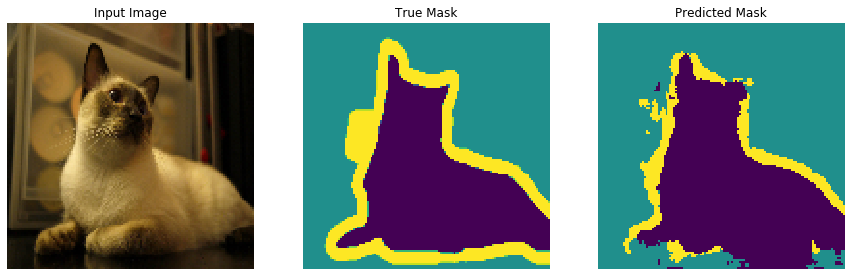


Sample Prediction after epoch 17

115/115 [==============================] - 26s 226ms/step - loss: 0.1683 - accuracy: 0.9247 - val_loss: 0.3715 - val_accuracy: 0.8720
Epoch 18/20
114/115 [============================>.] - ETA: 0s - loss: 0.1619 - accuracy: 0.9272

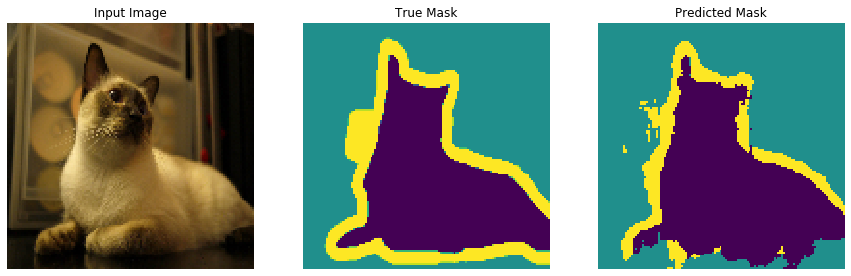


Sample Prediction after epoch 18

115/115 [==============================] - 27s 233ms/step - loss: 0.1619 - accuracy: 0.9273 - val_loss: 0.3454 - val_accuracy: 0.8785
Epoch 19/20
114/115 [============================>.] - ETA: 0s - loss: 0.1575 - accuracy: 0.9291

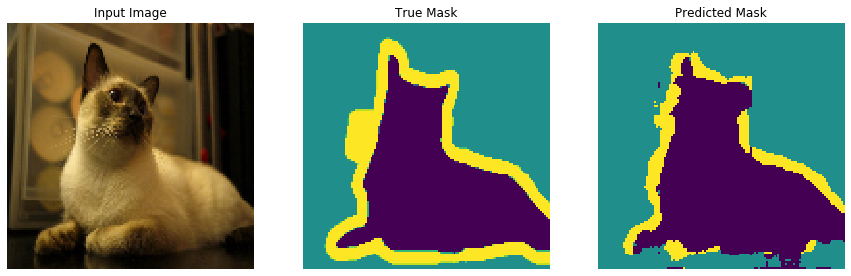


Sample Prediction after epoch 19

115/115 [==============================] - 27s 236ms/step - loss: 0.1574 - accuracy: 0.9292 - val_loss: 0.3636 - val_accuracy: 0.8784
Epoch 20/20
114/115 [============================>.] - ETA: 0s - loss: 0.1525 - accuracy: 0.9310

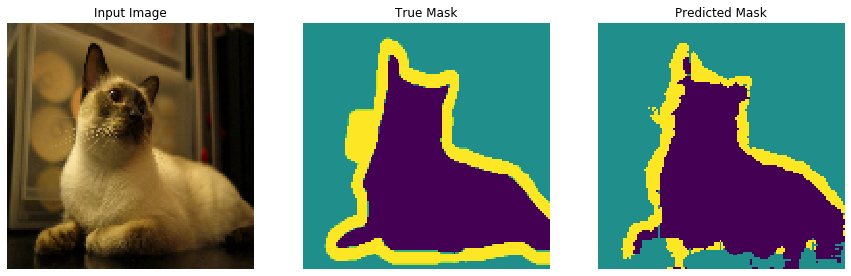


Sample Prediction after epoch 20

115/115 [==============================] - 27s 233ms/step - loss: 0.1526 - accuracy: 0.9310 - val_loss: 0.3581 - val_accuracy: 0.8747


In [23]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

history = model.fit(train_dataset, epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_steps=VALIDATION_STEPS,
                    validation_data=test_dataset,
                    callbacks=[DisplayCallback()])

<function matplotlib.pyplot.show(*args, **kw)>

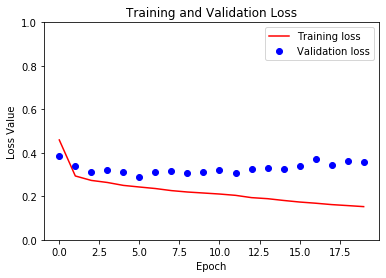

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0,1])
plt.legend(loc=1)
plt.show

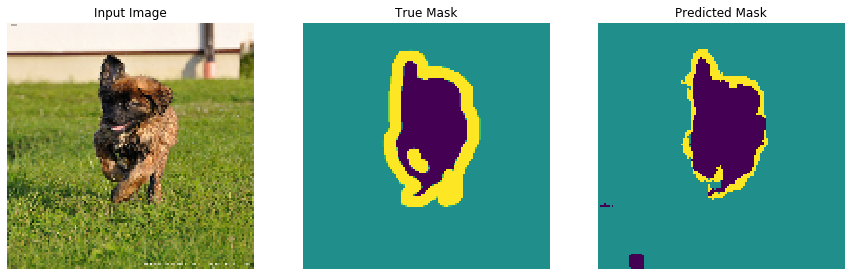

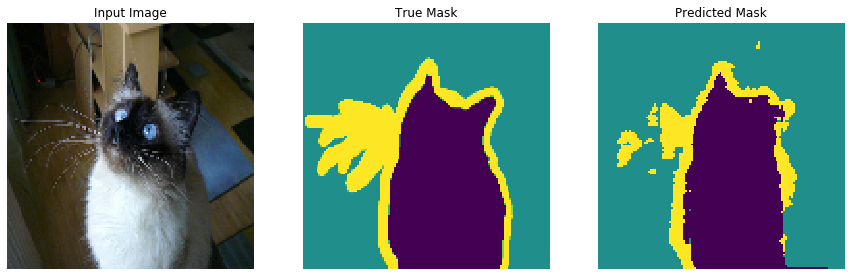

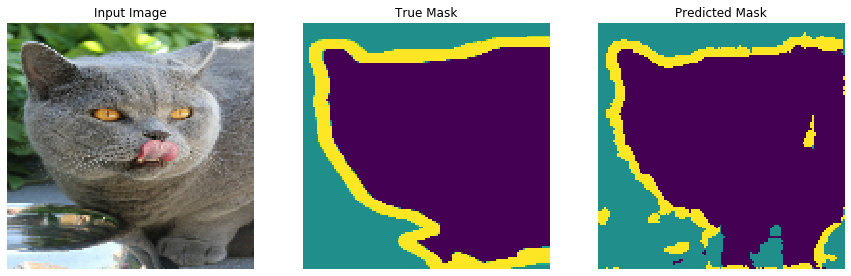

In [27]:
show_predictions(test_dataset, 3)